## Setup

In [5]:
import json, time, pathlib
import matplotlib.pyplot as plt
import concurrent.futures

from pprint import pprint

import sklearn.datasets
import sklearn.metrics
from sklearn.inspection import plot_partial_dependence, permutation_importance

import autosklearn.classification

import concurrent.futures
import time

import sys, os

sys.path.insert(0, os.path.abspath(os.path.join('..', 'src')))

from AutoSklearn.with_ensemble import with_ensemble_experiment
from AutoSklearn.without_ensemble import without_ensemble_experiment


## Load Dataset

In [6]:
dataset_name = 'iris'

X, y = sklearn.datasets.fetch_openml(name=dataset_name, version=1, return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, random_state=1
)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((112, 4), (112,), (38, 4), (38,))

## Experiments Parameters

In [7]:
time_limit = 60 * 5  # 60 * número de minutos
tmp_path = pathlib.Path('../results/tmp/' + dataset_name)

## Experiments Functions

Iniciando experimento COM ensemble...
Iniciando experimento SEM ensemble...


/home/joao/miniconda3/envs/as-env/lib/python3.9/site-packages/autosklearn/data/target_validator.py:187: UserWarning: Fitting transformer with a pandas series which has the dtype category. Inverse transform may not be able preserve dtype when converting to np.ndarray
  warnings.warn(
/home/joao/miniconda3/envs/as-env/lib/python3.9/site-packages/autosklearn/data/target_validator.py:187: UserWarning: Fitting transformer with a pandas series which has the dtype category. Inverse transform may not be able preserve dtype when converting to np.ndarray
  warnings.warn(


[WARNING] [2025-07-19 15:15:11,982:smac.runhistory.runhistory2epm.RunHistory2EPM4LogCost] Got cost of smaller/equal to 0. Replace by 0.000010 since we use log cost.
[WARNING] [2025-07-19 15:15:12,944:smac.runhistory.runhistory2epm.RunHistory2EPM4LogCost] Got cost of smaller/equal to 0. Replace by 0.000010 since we use log cost.
[WARNING] [2025-07-19 15:15:15,682:smac.runhistory.runhistory2epm.RunHistory2EPM4LogCost] Got cost of smaller/equal to 0. Replace by 0.000010 since we use log cost.
[WARNING] [2025-07-19 15:15:18,420:smac.runhistory.runhistory2epm.RunHistory2EPM4LogCost] Got cost of smaller/equal to 0. Replace by 0.000010 since we use log cost.
[WARNING] [2025-07-19 15:15:22,388:smac.runhistory.runhistory2epm.RunHistory2EPM4LogCost] Got cost of smaller/equal to 0. Replace by 0.000010 since we use log cost.
[WARNING] [2025-07-19 15:15:25,187:smac.runhistory.runhistory2epm.RunHistory2EPM4LogCost] Got cost of smaller/equal to 0. Replace by 0.000010 since we use log cost.
[WARNING] 

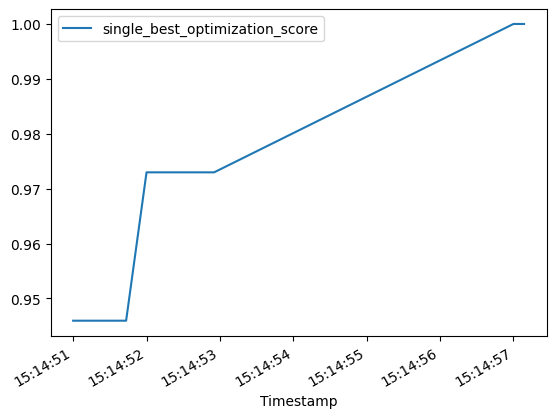

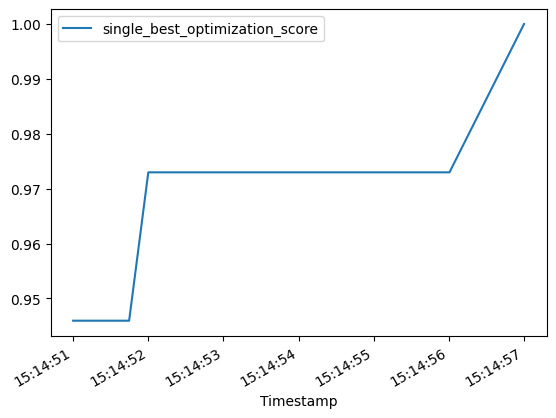

In [8]:
start_time = time.time()

results = {}

def process_result(experiment_name, automl_model):
    """Processa o resultado quando a thread termina"""
    print(f"{experiment_name} concluído!")
    
    predictions = automl_model.predict(X_test)
    accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
    
    results[experiment_name] = {
        'model': automl_model,
        'accuracy': accuracy,
        'predictions': predictions
    }

    df = automl_model.performance_over_time_
    df.plot(x='Timestamp', y='single_best_optimization_score', kind='line')
    
    with open('../results/results.txt', 'a') as f:
        if experiment_name == 'COM ensemble':
            f.write(f"{dataset_name} - With ensemble:\n")
        else:
            f.write(f"{dataset_name} - Without ensemble:\n")
        f.write(f"Accuracy score: {accuracy}\n")
        elapsed_time = time.time() - start_time
        minutes = int(elapsed_time // 60)
        seconds = int(elapsed_time % 60)
        f.write(f"Finished in: {minutes}m and {seconds}s\n\n")

with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
    print("Iniciando experimento COM ensemble...")
    future_with = executor.submit(
        with_ensemble_experiment, 
        X_train, y_train, time_limit, dataset_name, tmp_path / 'with_ensemble'
    )
    
    print("Iniciando experimento SEM ensemble...")
    future_without = executor.submit(
        without_ensemble_experiment, 
        X_train, y_train, time_limit, dataset_name, tmp_path / 'without_ensemble'
    )
    
    for future in concurrent.futures.as_completed([future_with, future_without]):
        if future == future_with:
            automl_with_ensemble = future.result()
            process_result("COM ensemble", automl_with_ensemble)
        else:
            automl_without_ensemble = future.result()
            process_result("SEM ensemble", automl_without_ensemble)

total_time = time.time() - start_time
print(f"Todos os experimentos concluídos em {total_time:.2f} segundos")

In [9]:
for result in results:
    print(f"Resultado para {result} teve acurácia de {results[result]['accuracy']:.2f}")
    print("Construção do modelo:")
    print(results[result]['model'].leaderboard(sort_by='cost'))
    print()


Resultado para SEM ensemble teve acurácia de 0.97
Construção do modelo:
          rank  ensemble_weight        type  cost  duration
model_id                                                   
82           1              1.0  libsvm_svc   0.0  0.712383

Resultado para COM ensemble teve acurácia de 0.97
Construção do modelo:
          rank  ensemble_weight                 type      cost  duration
model_id                                                                
21           4             0.02    gradient_boosting  0.000000  0.982388
28           2             0.06           libsvm_svc  0.000000  0.834551
48           5             0.02           libsvm_svc  0.000000  0.852242
59           3             0.06           libsvm_svc  0.000000  0.836383
93           1             0.02           libsvm_svc  0.000000  0.792928
8           11             0.02                  mlp  0.027027  0.989037
9           10             0.04           libsvm_svc  0.027027  0.592775
19          15    

In [10]:
for result in results:
    print(f"Resultado para {result} teve acurácia de {results[result]['accuracy']:.2f}")
    print("Construção do modelo:")
    pprint(results[result]['model'].show_models(), indent=4)
    print()


Resultado para SEM ensemble teve acurácia de 0.97
Construção do modelo:
{   82: {   'balancing': Balancing(random_state=1, strategy='weighting'),
            'classifier': <autosklearn.pipeline.components.classification.ClassifierChoice object at 0x785aa0adc370>,
            'cost': 0.0,
            'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x785b10bfc8e0>,
            'ensemble_weight': 1.0,
            'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice object at 0x785b10bc4130>,
            'model_id': 82,
            'rank': 1,
            'sklearn_classifier': SVC(C=8695.81473913779, cache_size=2564.8359375, class_weight='balanced',
    gamma=4.516753211414294e-05, kernel='sigmoid', max_iter=-1.0,
    random_state=1, shrinking=False, tol=0.00329854623686463)}}

Resultado para COM ensemble teve acurácia de 0.97
Construção do modelo:
{   2: {   'balancing': Balancing(

## Explaining the models

## Lista de próximas etapas:

- Verificar informações dos modelos de pre processamento

- Testar com outros datasets (mnist e wine quality dataset)

- Testar o imdb com mais tempo para estourar o teto

- Melhorar estrutura para salver os resultados dos exprimentos com mais métricas as e os gráficos

### Outros tópicos

- Pesquisar sobre SHAP e interpretabilidade
- Começar a usar o TPOT ou H2O